In [ ]:
# Copyright (c) Innoptech

# **General Template Matching with OpenFDCM**

This notebook demonstrates general template matching using the OpenFDCM library.
Unlike the [other notebook which focused on pose estimation](https://github.com/Innoptech/OpenFDCM/blob/main/notebooks/pose_extimation_example.ipynb), this notebook covers basic template matching techniques.
We will:
- Decode images from Base64 strings,
- Detect lines using OpenCV's Fast Line Detector,
- Match templates efficiently using the OpenFDCM library.

Let's get started by importing the necessary libraries and defining utility functions.


<a target="_blank" href="https://colab.research.google.com/drive/1-GvhZFliCvRVX1q_0LYdrS32x7hRTX98?usp=sharing">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab">
</a>

### Environment Set-up

* If running locally using jupyter, first install `openfdcm==0.8.1` in your environment using the installation instructions in the repository.

* If running from Google Colab, set using_colab=True below and run the cell.

In [1]:
using_colab = True

In [ ]:
# Install required libraries
if using_colab:
  import sys
  !{sys.executable} -m pip install openfdcm==0.8.1
  !{sys.executable} -m pip install numpy==2.1.0 opencv-python-headless==4.10.0.84

### Set-up

In [ ]:
import time
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import openfdcm
print("OpenFDCM version:", openfdcm.__version__)

In [4]:
def detect_lines(image):
    fld = cv2.ximgproc.createFastLineDetector()
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    lines = fld.detect(image_gray)
    return np.squeeze(lines).T

def convert_lines_to_array(lines):
    num_lines = len(lines)
    line_array = np.zeros((4, num_lines))
    for i, line in enumerate(lines):
        line_array[:, i] = line[0]
    return line_array

def apply_transform(template, transform):
    num_lines = template.shape[1]
    transformed_template = np.zeros_like(template)
    for i in range(num_lines):
        point1 = np.dot(transform[:2, :2], template[:2, i]) + transform[:2, 2]
        point2 = np.dot(transform[:2, :2], template[2:, i]) + transform[:2, 2]
        transformed_template[:2, i] = point1
        transformed_template[2:, i] = point2
    return transformed_template

def draw_lines(image, lines):
    for i in range(lines.shape[1]):
        pt1 = (int(lines[0, i]), int(lines[1, i]))
        pt2 = (int(lines[2, i]), int(lines[3, i]))
        cv2.line(image, pt1, pt2, (255, 0, 0), 2)
    return image

def display_best_match(scene_image_color: np.ndarray, tmpl_image_color: np.ndarray,
                       best_matches: list[openfdcm.Match], templates: list[np.ndarray]):
    scene_image_color = np.array(scene_image_color)[:, :, ::-1] # BGR -> RGB
    tmpl_image_color = np.array(tmpl_image_color)[:, :, ::-1] # BGR -> RGB

    result_image = scene_image_color.copy()
    for match in best_matches:
        best_match_template = templates[match.tmpl_idx]
        transformed_template = apply_transform(best_match_template, match.transform)
        result_image = draw_lines(result_image, transformed_template)

    # Display Images
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(tmpl_image_color)
    axes[0].set_title('Template')
    axes[0].axis('off')

    axes[1].imshow(scene_image_color)
    axes[1].set_title('Scene')
    axes[1].axis('off')

    axes[2].imshow(result_image)
    axes[2].set_title('Best Match')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


### Download scene and template from the web

In [34]:
!mkdir -p images_web
!wget -P images_web https://raw.githubusercontent.com/Innoptech/OpenFDCM/tree/v0.8.1/notebooks/assets/ulaval_laboratoire_robotique_scene.png
!wget -P images_web https://raw.githubusercontent.com/Innoptech/OpenFDCM/tree/v0.8.1/notebooks/assets/ulaval_laboratoire_robotique_tmpl.png
!wget -P images_web https://raw.githubusercontent.com/Innoptech/OpenFDCM/tree/v0.8.1/notebooks/assets/logo_innoptech.png

tmpl1_image_base64 = "images_web/ulaval_laboratoire_robotique_tmpl.png"
tmpl2_image_base64 = "images_web/logo_innoptech.png"
scene_image_base64 = "images_web/ulaval_laboratoire_robotique_scene.png"

Template matching search completed in 0.2195 seconds.
Number of unfiltered match candidates: 1928.


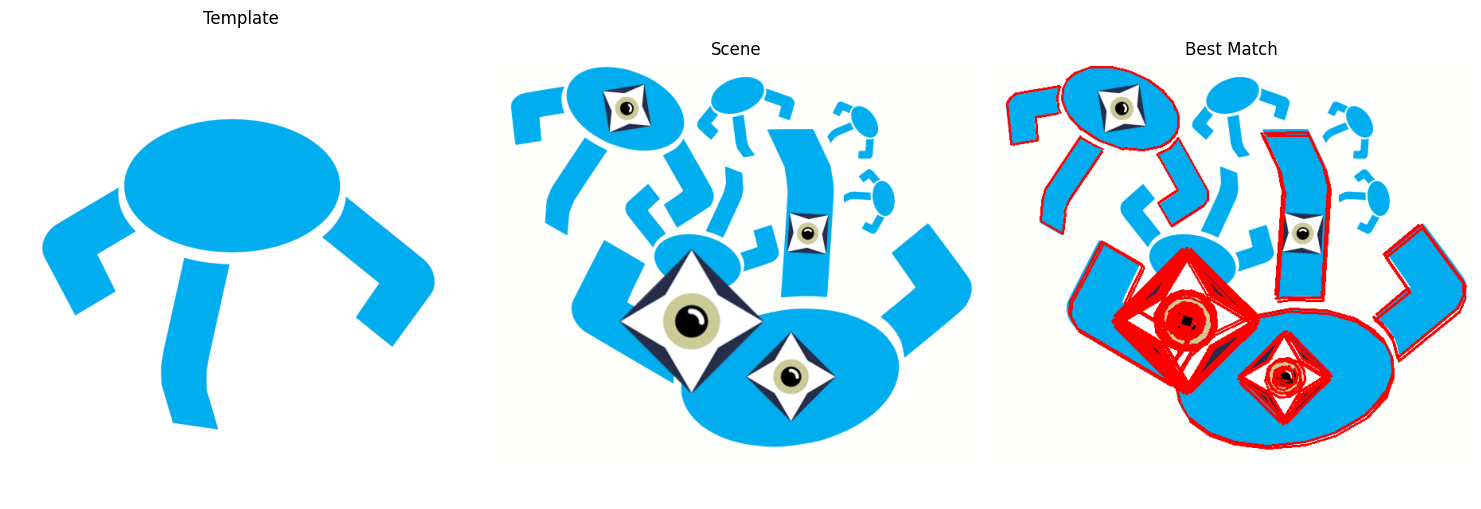

In [113]:
tmpl1_image = cv2.imread(tmpl1_image_base64)
tmpl2_image = cv2.imread(tmpl2_image_base64)
scene_image = cv2.imread(scene_image_base64)

# Define a resolution scale (influence speed)
scale = 0.5

# Detect lines using Fast Line Detector
tmpl1_lines = detect_lines(tmpl1_image)*scale
tmpl2_lines = detect_lines(tmpl2_image)*scale
scene_lines = detect_lines(scene_image)*scale

# Define a template for multiple scales
templates1 = [tmpl1_lines * scale for scale in np.linspace(0.1, 0.8, 25)]
templates2 = [tmpl2_lines * scale for scale in np.linspace(0.3, 1, 20)]
all_templates = templates1 + templates2

# Perform template matching using OpenFDCM
max_tmpl_lines, max_scene_lines = 3, 10  # Combinatory search parameters.
depth = 30              # The [0, pi] discretization.
scene_padding = 1.0     # A ratio to pad the scene images used in the FDCM algorithm, use if best match may appear on image boundaries.
coeff = 5.0             # A weighting factor to enhance the angular cost vs distance cost in FDCM algorithm.
#num_threads = 4

threadpool = openfdcm.ThreadPool() # could pass num_threads here, but default is optimal
search_strategy = openfdcm.DefaultSearch(max_tmpl_lines, max_scene_lines)
optimizer_strategy = openfdcm.BatchOptimize(5, threadpool)
matcher = openfdcm.DefaultMatch()
# Penalize each match with 1/n^tau where n is the number of line in the template
penalizer = openfdcm.ExponentialPenalty(tau=1.5)

start_time = time.time()
featuremap_params = openfdcm.Dt3CpuParameters(depth=depth, dt3Coeff=coeff, padding=scene_padding)
featuremap = openfdcm.build_cpu_featuremap(scene_lines, featuremap_params, threadpool)
raw_matches = openfdcm.search(matcher, search_strategy, optimizer_strategy, featuremap, all_templates, scene_lines)
penalized_matches = openfdcm.penalize(penalizer, raw_matches, openfdcm.get_template_lengths(all_templates))
sorted_matches = openfdcm.sort_matches(penalized_matches)
search_time = time.time() - start_time
print(f"Template matching search completed in {search_time:.4f} seconds.")
print(f"Number of unfiltered match candidates: {len(penalized_matches)}.")

if sorted_matches:
    best_matches = sorted_matches[:30]
    for match in best_matches:
      transform = np.array(match.transform)
      transform[:,2] /= scale
      match.transform = transform.tolist()
    scaled_templates = [tmpl/scale for tmpl in all_templates]
    display_best_match(scene_image, tmpl1_image, best_matches, scaled_templates)
